Установим необходимые библиотеки и импортируем зависимости

In [ ]:
!pip install torch
!pip install torchvision
!pip install pandas

In [ ]:
import torch
import torchvision
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch import optim

from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from itertools import product


Подготовим данные для обучения

In [53]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, ), std=(0.5, ))
])

In [ ]:
train_dataset = MNIST(
    root="./dataset", 
    train=True, 
    download=True, 
    transform=transform)

test_dataset = MNIST(
    root="./dataset", 
    train=False, 
    download=True, 
    transform=transform)

In [47]:
len(train_dataset), len(test_dataset)

(60000, 10000)

In [51]:
trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

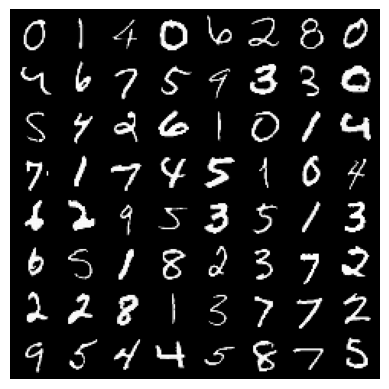

In [50]:
def imshow(img_tensor):
    np_img = img_tensor.numpy()
    np_img = np.transpose(np_img, (1, 2, 0))
    np_img = np.clip(np_img, 0, 1)
    plt.imshow(np_img)
    plt.axis('off')

images, labels = next(iter(trainloader))
grid = torchvision.utils.make_grid(images) 
imshow(grid)
plt.show()

Построим слои для нейронной сети и саму сеть


In [57]:
class FullyConnectedLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(in_features, out_features) * 0.1)
        self.bias = nn.Parameter(torch.zeros(out_features))

    def forward(self, x):
        self.x = x
        return x @ self.weight + self.bias 


class ReluLayer(nn.Module):
    def forward(self, x):
        self.x = x
        return F.relu(x)

In [58]:
class NeuralNetwork(nn.Module):
    def __init__(self, hidden_size=128, batch_normalization=False):
        super().__init__()
        self.batch_normalization = batch_normalization

        self.fc1 = FullyConnectedLayer(1*28*28, hidden_size)
        self.relu1 = ReluLayer() 
        self.bn1 = nn.BatchNorm1d(hidden_size) if batch_normalization else None
        self.fc2 = FullyConnectedLayer(hidden_size, 10)

    def forward(self, x):
        x = x.view(-1, 1*28*28)
        x = self.fc1(x)
        x = self.relu1(x)
        if self.batch_normalization:
            x = self.bn1(x)
        x = self.fc2(x)
        return x

Оптимизатор Adam


In [72]:
class AdamOptimizer:
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0.0):
        self.params = list(params)
        self.lr = lr
        self.beta1, self.beta2 = betas
        self.eps = eps
        self.weight_decay = weight_decay
        self.t = 0
        
        self.m = [torch.zeros_like(p.data) for p in self.params]
        self.v = [torch.zeros_like(p.data) for p in self.params]

    def step(self):
        self.t += 1
        for i, param in enumerate(self.params):
            if param.grad is None:
                continue
                
            grad = param.grad.data
            
            # L2-регуляризация
            if self.weight_decay != 0:
                grad += self.weight_decay * param.data
                
            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * grad
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * grad.pow(2)
            
            m_hat = self.m[i] / (1 - self.beta1**self.t)
            v_hat = self.v[i] / (1 - self.beta2**self.t)
            
            param.data -= self.lr * m_hat / (v_hat.sqrt() + self.eps)
            
    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.detach_()
                param.grad.zero_()

def get_optimizer(name, params, lr, **kwargs):
    optimizers = {
        'adam': lambda: AdamOptimizer(params, lr=lr, **kwargs),
        'momentum': lambda: optim.SGD(params, lr=lr, momentum=0.9, **kwargs),
        'sgd': lambda: optim.SGD(params, lr=lr, **kwargs)
    }
    
    if name not in optimizers:
        raise ValueError(f"Unknown optimizer: {name}. Available: {list(optimizers.keys())}")
    
    return optimizers[name]()

Обучение c проверкой градиентов


In [110]:
import torch
import torch.nn as nn

def gradient_check(model, input_size, loss_fn, num_samples=3, eps=1e-6, atol=1e-4):
    model.train() 
    original_dtype = next(model.parameters()).dtype
    model = model.double()
    
    inputs = torch.randn(num_samples, *input_size, dtype=torch.double, requires_grad=True)
    targets = torch.randint(0, 10, (num_samples,))

    def func(inputs):
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        return loss

    test_result = torch.autograd.gradcheck(
        func, inputs, eps=eps, atol=atol, raise_exception=False
    )
    
    model = model.to(original_dtype)
    return test_result

def train_model(model, train_loader, test_loader, loss_fn, optimizer, num_epochs=10, check_gradients=False):
    history = {
        'train_loss': [],
        'val_loss': [],
    }

    if check_gradients:
        test_input = next(iter(train_loader))[0][0].unsqueeze(0)
        grad_check = gradient_check(model, test_input.shape[1:], loss_fn)
        print(f"Gradients check: {'Success' if grad_check else 'Fail'}")
        
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        total_samples = 0
        
        for i, (inputs, targets) in enumerate(train_loader):
            # forward pass
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            
            if check_gradients and i % 100 == 0:
                grad_check = gradient_check(model, inputs[0].shape, loss_fn)
                print(f"Epoch {epoch}, batch {i}: {'Gradients OK' if grad_check else 'GRADIENT PROBLEM!'}")
                
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            total_samples += inputs.size(0)

        # Calculate epoch training loss
        epoch_train_loss = running_loss / total_samples
        history['train_loss'].append(epoch_train_loss)
        
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, targets in test_loader:
                outputs = model(inputs)
                loss = loss_fn(outputs, targets)
                
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                correct += (predicted == targets).sum().item()
                total += targets.size(0)
        
        # Calculate validation metrics
        epoch_val_loss = val_loss / total
        history['val_loss'].append(epoch_val_loss)
        
        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {epoch_train_loss:.4f} | "
              f"Val Loss: {epoch_val_loss:.4f} | ")
    
    return model, history

Gradients check: Success
Epoch 0, batch 0: Gradients OK
Epoch 0, batch 100: Gradients OK
Epoch 0, batch 200: Gradients OK
Epoch 0, batch 300: Gradients OK
Epoch 0, batch 400: Gradients OK
Epoch 0, batch 500: Gradients OK
Epoch 0, batch 600: Gradients OK
Epoch 0, batch 700: Gradients OK
Epoch 0, batch 800: Gradients OK
Epoch 0, batch 900: Gradients OK
Epoch 1/10 | Train Loss: 0.3726 | Val Loss: 0.2073 | 
Epoch 1, batch 0: Gradients OK
Epoch 1, batch 100: Gradients OK
Epoch 1, batch 200: Gradients OK
Epoch 1, batch 300: Gradients OK
Epoch 1, batch 400: Gradients OK
Epoch 1, batch 500: Gradients OK
Epoch 1, batch 600: Gradients OK
Epoch 1, batch 700: Gradients OK
Epoch 1, batch 800: Gradients OK
Epoch 1, batch 900: Gradients OK
Epoch 2/10 | Train Loss: 0.1836 | Val Loss: 0.1662 | 
Epoch 2, batch 0: Gradients OK
Epoch 2, batch 100: Gradients OK
Epoch 2, batch 200: Gradients OK
Epoch 2, batch 300: Gradients OK
Epoch 2, batch 400: Gradients OK
Epoch 2, batch 500: Gradients OK
Epoch 2, batch 

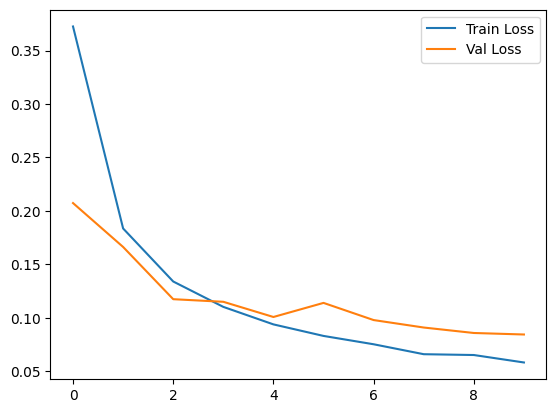

In [113]:
model = NeuralNetwork()
loss_fn = nn.CrossEntropyLoss()
optimizer = AdamOptimizer(
    model.parameters(),
    lr=0.001,
    betas=(0.9, 0.999),
    weight_decay=1e-4  # Коэффициент L2-регуляризации
)

trained_model, history = train_model(
    model,
    trainloader,
    testloader,
    loss_fn,
    optimizer,
    num_epochs=10,
    check_gradients=True
)

plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.legend()
plt.show()

Сделаем перебор параметров модели и посмотрим результаты

In [120]:
config = {
    'models': [{'batch_norm': False, 'seed': 42}, 
               {'batch_norm': True, 'seed': 42}],
    'lr': [0.001, 0.01],
    'optimizers': ['adam', 'momentum', 'sgd'],
}

In [121]:
def run_experiments(models, lrs, optimizers, num_epochs=10):
    torch.manual_seed(42)
    results = []
    
    for model_config, lr, optim_name in product(models, lrs, optimizers):
        model = NeuralNetwork(batch_normalization=model_config['batch_norm'])
        criterion = nn.CrossEntropyLoss()
        optimizer = get_optimizer(optim_name, model.parameters(), lr)

        print(f"\nTraining {model.__class__.__name__} "
              f"with lr={lr}, optimizer={optim_name}, "
              f"batch norm={model_config['batch_norm']}")
        
        _, history = train_model(
            model,
            trainloader,
            testloader,
            criterion,
            optimizer,
            num_epochs=10,
            check_gradients = True
        )

        plt.plot(history['train_loss'], label='Train Loss')
        plt.plot(history['val_loss'], label='Val Loss')
        plt.legend()
        plt.show()
        print(results)
    
    return results


Training NeuralNetwork with lr=0.001, optimizer=adam, batch norm=False
Gradients check: Success
Epoch 0, batch 0: Gradients OK
Epoch 0, batch 100: Gradients OK
Epoch 0, batch 200: Gradients OK
Epoch 0, batch 300: Gradients OK
Epoch 0, batch 400: Gradients OK
Epoch 0, batch 500: Gradients OK
Epoch 0, batch 600: Gradients OK
Epoch 0, batch 700: Gradients OK
Epoch 0, batch 800: Gradients OK
Epoch 0, batch 900: Gradients OK
Epoch 1/10 | Train Loss: 0.3540 | Val Loss: 0.1891 | 
Epoch 1, batch 0: Gradients OK
Epoch 1, batch 100: Gradients OK
Epoch 1, batch 200: Gradients OK
Epoch 1, batch 300: Gradients OK
Epoch 1, batch 400: Gradients OK
Epoch 1, batch 500: Gradients OK
Epoch 1, batch 600: Gradients OK
Epoch 1, batch 700: Gradients OK
Epoch 1, batch 800: Gradients OK
Epoch 1, batch 900: Gradients OK
Epoch 2/10 | Train Loss: 0.1672 | Val Loss: 0.1365 | 
Epoch 2, batch 0: Gradients OK
Epoch 2, batch 100: Gradients OK
Epoch 2, batch 200: Gradients OK
Epoch 2, batch 300: Gradients OK
Epoch 2, 

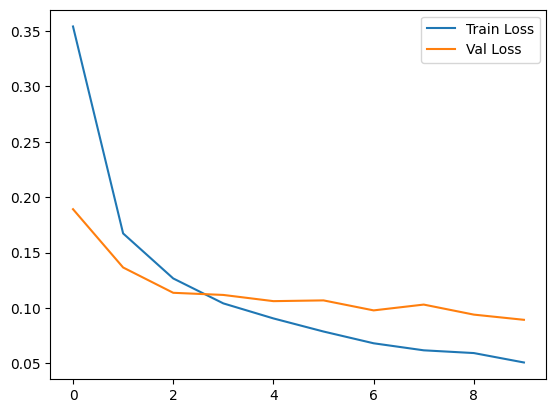

[]

Training NeuralNetwork with lr=0.001, optimizer=momentum, batch norm=False
Gradients check: Success
Epoch 0, batch 0: Gradients OK
Epoch 0, batch 100: Gradients OK
Epoch 0, batch 200: Gradients OK
Epoch 0, batch 300: Gradients OK
Epoch 0, batch 400: Gradients OK
Epoch 0, batch 500: Gradients OK
Epoch 0, batch 600: Gradients OK
Epoch 0, batch 700: Gradients OK
Epoch 0, batch 800: Gradients OK
Epoch 0, batch 900: Gradients OK
Epoch 1/10 | Train Loss: 0.6710 | Val Loss: 0.3815 | 
Epoch 1, batch 0: Gradients OK
Epoch 1, batch 100: Gradients OK
Epoch 1, batch 200: Gradients OK
Epoch 1, batch 300: Gradients OK
Epoch 1, batch 400: Gradients OK
Epoch 1, batch 500: Gradients OK
Epoch 1, batch 600: Gradients OK
Epoch 1, batch 700: Gradients OK
Epoch 1, batch 800: Gradients OK
Epoch 1, batch 900: Gradients OK
Epoch 2/10 | Train Loss: 0.3586 | Val Loss: 0.3159 | 
Epoch 2, batch 0: Gradients OK
Epoch 2, batch 100: Gradients OK
Epoch 2, batch 200: Gradients OK
Epoch 2, batch 300: Gradients OK
Ep

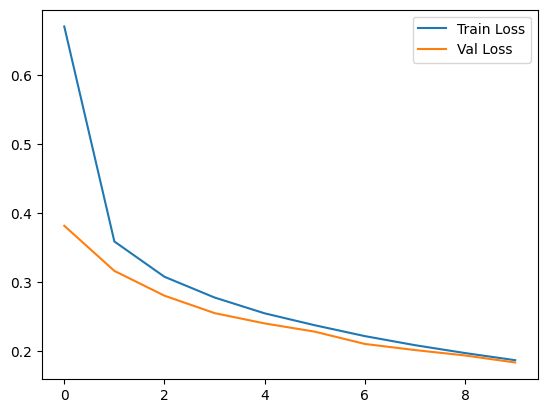

[]

Training NeuralNetwork with lr=0.001, optimizer=sgd, batch norm=False
Gradients check: Success
Epoch 0, batch 0: Gradients OK
Epoch 0, batch 100: Gradients OK
Epoch 0, batch 200: Gradients OK
Epoch 0, batch 300: Gradients OK
Epoch 0, batch 400: Gradients OK
Epoch 0, batch 500: Gradients OK
Epoch 0, batch 600: Gradients OK
Epoch 0, batch 700: Gradients OK
Epoch 0, batch 800: Gradients OK
Epoch 0, batch 900: Gradients OK
Epoch 1/10 | Train Loss: 1.5003 | Val Loss: 0.9127 | 
Epoch 1, batch 0: Gradients OK
Epoch 1, batch 100: Gradients OK
Epoch 1, batch 200: Gradients OK
Epoch 1, batch 300: Gradients OK
Epoch 1, batch 400: Gradients OK
Epoch 1, batch 500: Gradients OK
Epoch 1, batch 600: Gradients OK
Epoch 1, batch 700: Gradients OK
Epoch 1, batch 800: Gradients OK
Epoch 1, batch 900: Gradients OK
Epoch 2/10 | Train Loss: 0.7814 | Val Loss: 0.6557 | 
Epoch 2, batch 0: Gradients OK
Epoch 2, batch 100: Gradients OK
Epoch 2, batch 200: Gradients OK
Epoch 2, batch 300: Gradients OK
Epoch 2

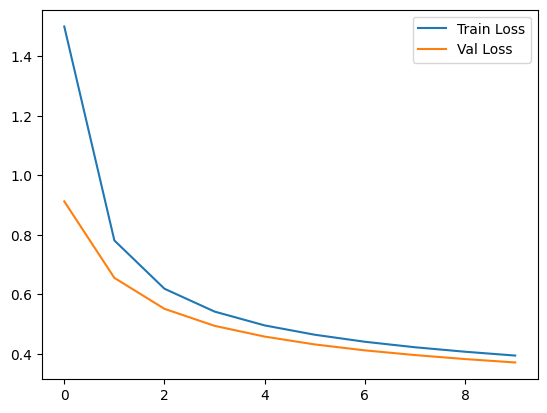

[]

Training NeuralNetwork with lr=0.01, optimizer=adam, batch norm=False
Gradients check: Success
Epoch 0, batch 0: Gradients OK
Epoch 0, batch 100: Gradients OK
Epoch 0, batch 200: Gradients OK
Epoch 0, batch 300: Gradients OK
Epoch 0, batch 400: Gradients OK
Epoch 0, batch 500: Gradients OK
Epoch 0, batch 600: Gradients OK
Epoch 0, batch 700: Gradients OK
Epoch 0, batch 800: Gradients OK
Epoch 0, batch 900: Gradients OK
Epoch 1/10 | Train Loss: 0.4877 | Val Loss: 0.3111 | 
Epoch 1, batch 0: Gradients OK
Epoch 1, batch 100: Gradients OK
Epoch 1, batch 200: Gradients OK
Epoch 1, batch 300: Gradients OK
Epoch 1, batch 400: Gradients OK
Epoch 1, batch 500: Gradients OK
Epoch 1, batch 600: Gradients OK
Epoch 1, batch 700: Gradients OK
Epoch 1, batch 800: Gradients OK
Epoch 1, batch 900: Gradients OK
Epoch 2/10 | Train Loss: 0.3044 | Val Loss: 0.2986 | 
Epoch 2, batch 0: Gradients OK
Epoch 2, batch 100: Gradients OK
Epoch 2, batch 200: Gradients OK
Epoch 2, batch 300: Gradients OK
Epoch 2

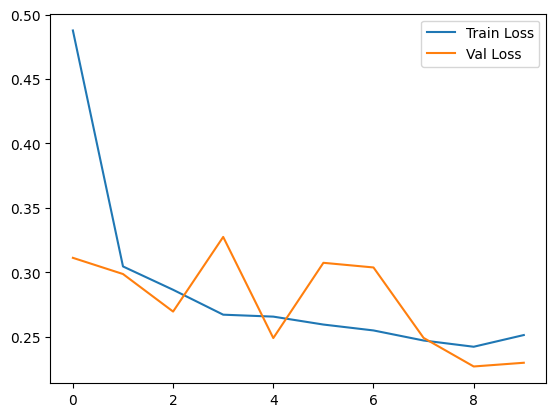

[]

Training NeuralNetwork with lr=0.01, optimizer=momentum, batch norm=False
Gradients check: Success
Epoch 0, batch 0: Gradients OK
Epoch 0, batch 100: Gradients OK
Epoch 0, batch 200: Gradients OK
Epoch 0, batch 300: Gradients OK
Epoch 0, batch 400: Gradients OK
Epoch 0, batch 500: Gradients OK
Epoch 0, batch 600: Gradients OK
Epoch 0, batch 700: Gradients OK
Epoch 0, batch 800: Gradients OK
Epoch 0, batch 900: Gradients OK
Epoch 1/10 | Train Loss: 0.3606 | Val Loss: 0.2172 | 
Epoch 1, batch 0: Gradients OK
Epoch 1, batch 100: Gradients OK
Epoch 1, batch 200: Gradients OK
Epoch 1, batch 300: Gradients OK
Epoch 1, batch 400: Gradients OK
Epoch 1, batch 500: Gradients OK
Epoch 1, batch 600: Gradients OK
Epoch 1, batch 700: Gradients OK
Epoch 1, batch 800: Gradients OK
Epoch 1, batch 900: Gradients OK
Epoch 2/10 | Train Loss: 0.1850 | Val Loss: 0.1617 | 
Epoch 2, batch 0: Gradients OK
Epoch 2, batch 100: Gradients OK
Epoch 2, batch 200: Gradients OK
Epoch 2, batch 300: Gradients OK
Epo

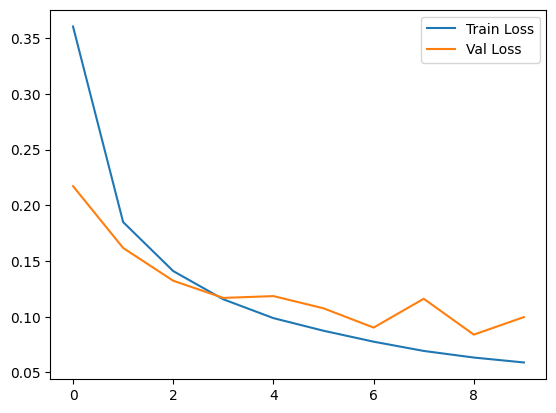

[]

Training NeuralNetwork with lr=0.01, optimizer=sgd, batch norm=False
Gradients check: Success
Epoch 0, batch 0: Gradients OK
Epoch 0, batch 100: Gradients OK
Epoch 0, batch 200: Gradients OK
Epoch 0, batch 300: Gradients OK
Epoch 0, batch 400: Gradients OK
Epoch 0, batch 500: Gradients OK
Epoch 0, batch 600: Gradients OK
Epoch 0, batch 700: Gradients OK
Epoch 0, batch 800: Gradients OK
Epoch 0, batch 900: Gradients OK
Epoch 1/10 | Train Loss: 0.6113 | Val Loss: 0.3783 | 
Epoch 1, batch 0: Gradients OK
Epoch 1, batch 100: Gradients OK
Epoch 1, batch 200: Gradients OK
Epoch 1, batch 300: Gradients OK
Epoch 1, batch 400: Gradients OK
Epoch 1, batch 500: Gradients OK
Epoch 1, batch 600: Gradients OK
Epoch 1, batch 700: Gradients OK
Epoch 1, batch 800: Gradients OK
Epoch 1, batch 900: Gradients OK
Epoch 2/10 | Train Loss: 0.3606 | Val Loss: 0.3432 | 
Epoch 2, batch 0: Gradients OK
Epoch 2, batch 100: Gradients OK
Epoch 2, batch 200: Gradients OK
Epoch 2, batch 300: Gradients OK
Epoch 2,

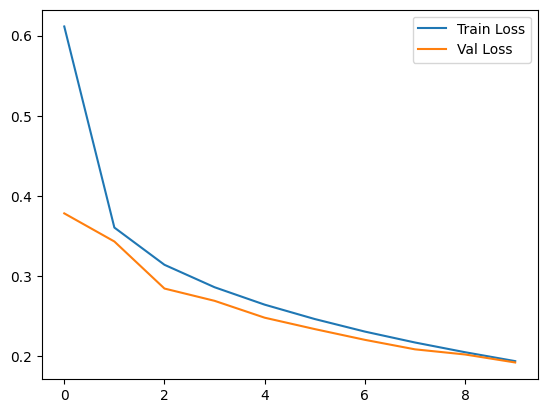

[]

Training NeuralNetwork with lr=0.001, optimizer=adam, batch norm=True
Gradients check: Success
Epoch 0, batch 0: Gradients OK
Epoch 0, batch 100: Gradients OK
Epoch 0, batch 200: Gradients OK
Epoch 0, batch 300: Gradients OK
Epoch 0, batch 400: Gradients OK
Epoch 0, batch 500: Gradients OK
Epoch 0, batch 600: Gradients OK
Epoch 0, batch 700: Gradients OK
Epoch 0, batch 800: Gradients OK
Epoch 0, batch 900: Gradients OK
Epoch 1/10 | Train Loss: 0.3520 | Val Loss: 0.2395 | 
Epoch 1, batch 0: Gradients OK
Epoch 1, batch 100: Gradients OK
Epoch 1, batch 200: Gradients OK
Epoch 1, batch 300: Gradients OK
Epoch 1, batch 400: Gradients OK
Epoch 1, batch 500: Gradients OK
Epoch 1, batch 600: Gradients OK
Epoch 1, batch 700: Gradients OK
Epoch 1, batch 800: Gradients OK
Epoch 1, batch 900: Gradients OK
Epoch 2/10 | Train Loss: 0.1993 | Val Loss: 0.1910 | 
Epoch 2, batch 0: Gradients OK
Epoch 2, batch 100: Gradients OK
Epoch 2, batch 200: Gradients OK
Epoch 2, batch 300: Gradients OK
Epoch 2

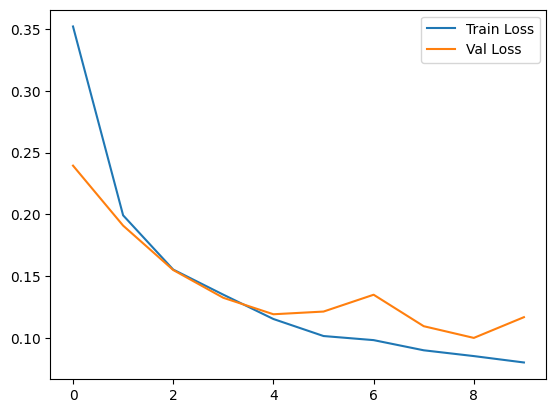

[]

Training NeuralNetwork with lr=0.001, optimizer=momentum, batch norm=True
Gradients check: Success
Epoch 0, batch 0: Gradients OK
Epoch 0, batch 100: Gradients OK
Epoch 0, batch 200: Gradients OK
Epoch 0, batch 300: Gradients OK
Epoch 0, batch 400: Gradients OK
Epoch 0, batch 500: Gradients OK
Epoch 0, batch 600: Gradients OK
Epoch 0, batch 700: Gradients OK
Epoch 0, batch 800: Gradients OK
Epoch 0, batch 900: Gradients OK
Epoch 1/10 | Train Loss: 0.6973 | Val Loss: 0.3922 | 
Epoch 1, batch 0: Gradients OK
Epoch 1, batch 100: Gradients OK
Epoch 1, batch 200: Gradients OK
Epoch 1, batch 300: Gradients OK
Epoch 1, batch 400: Gradients OK
Epoch 1, batch 500: Gradients OK
Epoch 1, batch 600: Gradients OK
Epoch 1, batch 700: Gradients OK
Epoch 1, batch 800: Gradients OK
Epoch 1, batch 900: Gradients OK
Epoch 2/10 | Train Loss: 0.3779 | Val Loss: 0.3089 | 
Epoch 2, batch 0: Gradients OK
Epoch 2, batch 100: Gradients OK
Epoch 2, batch 200: Gradients OK
Epoch 2, batch 300: Gradients OK
Epo

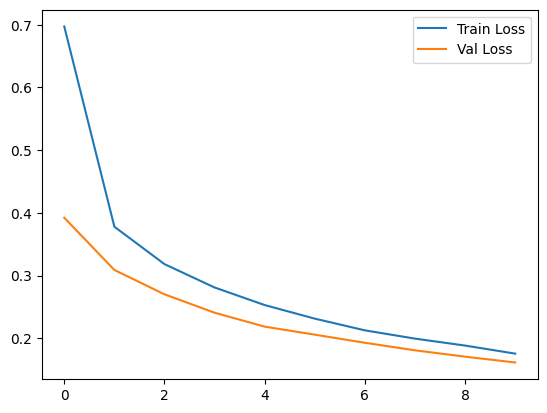

[]

Training NeuralNetwork with lr=0.001, optimizer=sgd, batch norm=True
Gradients check: Success
Epoch 0, batch 0: Gradients OK
Epoch 0, batch 100: Gradients OK
Epoch 0, batch 200: Gradients OK
Epoch 0, batch 300: Gradients OK
Epoch 0, batch 400: Gradients OK
Epoch 0, batch 500: Gradients OK
Epoch 0, batch 600: Gradients OK
Epoch 0, batch 700: Gradients OK
Epoch 0, batch 800: Gradients OK
Epoch 0, batch 900: Gradients OK
Epoch 1/10 | Train Loss: 1.6033 | Val Loss: 1.0253 | 
Epoch 1, batch 0: Gradients OK
Epoch 1, batch 100: Gradients OK
Epoch 1, batch 200: Gradients OK
Epoch 1, batch 300: Gradients OK
Epoch 1, batch 400: Gradients OK
Epoch 1, batch 500: Gradients OK
Epoch 1, batch 600: Gradients OK
Epoch 1, batch 700: Gradients OK
Epoch 1, batch 800: Gradients OK
Epoch 1, batch 900: Gradients OK
Epoch 2/10 | Train Loss: 0.8954 | Val Loss: 0.7418 | 
Epoch 2, batch 0: Gradients OK
Epoch 2, batch 100: Gradients OK
Epoch 2, batch 200: Gradients OK
Epoch 2, batch 300: Gradients OK
Epoch 2,

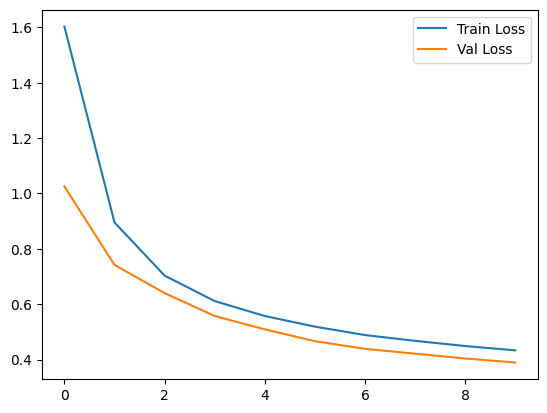

[]

Training NeuralNetwork with lr=0.01, optimizer=adam, batch norm=True
Gradients check: Success
Epoch 0, batch 0: Gradients OK
Epoch 0, batch 100: Gradients OK
Epoch 0, batch 200: Gradients OK
Epoch 0, batch 300: Gradients OK
Epoch 0, batch 400: Gradients OK
Epoch 0, batch 500: Gradients OK
Epoch 0, batch 600: Gradients OK
Epoch 0, batch 700: Gradients OK
Epoch 0, batch 800: Gradients OK
Epoch 0, batch 900: Gradients OK
Epoch 1/10 | Train Loss: 0.3774 | Val Loss: 0.3287 | 
Epoch 1, batch 0: Gradients OK
Epoch 1, batch 100: Gradients OK
Epoch 1, batch 200: Gradients OK
Epoch 1, batch 300: Gradients OK
Epoch 1, batch 400: Gradients OK
Epoch 1, batch 500: Gradients OK
Epoch 1, batch 600: Gradients OK
Epoch 1, batch 700: Gradients OK
Epoch 1, batch 800: Gradients OK
Epoch 1, batch 900: Gradients OK
Epoch 2/10 | Train Loss: 0.3133 | Val Loss: 0.3112 | 
Epoch 2, batch 0: Gradients OK
Epoch 2, batch 100: Gradients OK
Epoch 2, batch 200: Gradients OK
Epoch 2, batch 300: Gradients OK
Epoch 2,

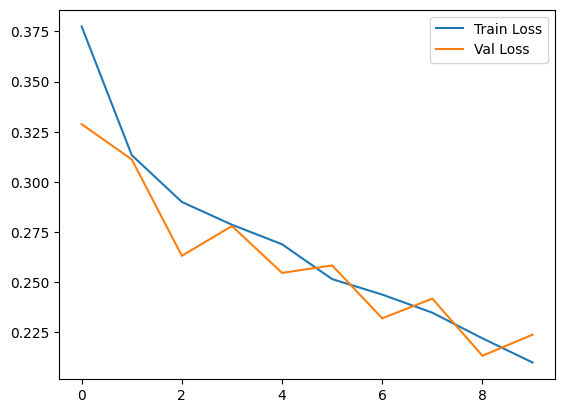

[]

Training NeuralNetwork with lr=0.01, optimizer=momentum, batch norm=True
Gradients check: Success
Epoch 0, batch 0: Gradients OK
Epoch 0, batch 100: Gradients OK
Epoch 0, batch 200: Gradients OK
Epoch 0, batch 300: Gradients OK
Epoch 0, batch 400: Gradients OK
Epoch 0, batch 500: Gradients OK
Epoch 0, batch 600: Gradients OK
Epoch 0, batch 700: Gradients OK
Epoch 0, batch 800: Gradients OK
Epoch 0, batch 900: Gradients OK
Epoch 1/10 | Train Loss: 0.3491 | Val Loss: 0.1998 | 
Epoch 1, batch 0: Gradients OK
Epoch 1, batch 100: Gradients OK
Epoch 1, batch 200: Gradients OK
Epoch 1, batch 300: Gradients OK
Epoch 1, batch 400: Gradients OK
Epoch 1, batch 500: Gradients OK
Epoch 1, batch 600: Gradients OK
Epoch 1, batch 700: Gradients OK
Epoch 1, batch 800: Gradients OK
Epoch 1, batch 900: Gradients OK
Epoch 2/10 | Train Loss: 0.1833 | Val Loss: 0.1457 | 
Epoch 2, batch 0: Gradients OK
Epoch 2, batch 100: Gradients OK
Epoch 2, batch 200: Gradients OK
Epoch 2, batch 300: Gradients OK
Epoc

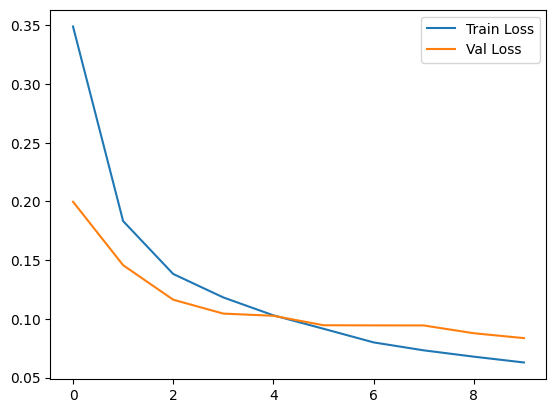

[]

Training NeuralNetwork with lr=0.01, optimizer=sgd, batch norm=True
Gradients check: Success
Epoch 0, batch 0: Gradients OK
Epoch 0, batch 100: Gradients OK
Epoch 0, batch 200: Gradients OK
Epoch 0, batch 300: Gradients OK
Epoch 0, batch 400: Gradients OK
Epoch 0, batch 500: Gradients OK
Epoch 0, batch 600: Gradients OK
Epoch 0, batch 700: Gradients OK
Epoch 0, batch 800: Gradients OK
Epoch 0, batch 900: Gradients OK
Epoch 1/10 | Train Loss: 0.6873 | Val Loss: 0.3870 | 
Epoch 1, batch 0: Gradients OK
Epoch 1, batch 100: Gradients OK
Epoch 1, batch 200: Gradients OK
Epoch 1, batch 300: Gradients OK
Epoch 1, batch 400: Gradients OK
Epoch 1, batch 500: Gradients OK
Epoch 1, batch 600: Gradients OK
Epoch 1, batch 700: Gradients OK
Epoch 1, batch 800: Gradients OK
Epoch 1, batch 900: Gradients OK
Epoch 2/10 | Train Loss: 0.3744 | Val Loss: 0.3060 | 
Epoch 2, batch 0: Gradients OK
Epoch 2, batch 100: Gradients OK
Epoch 2, batch 200: Gradients OK
Epoch 2, batch 300: Gradients OK
Epoch 2, 

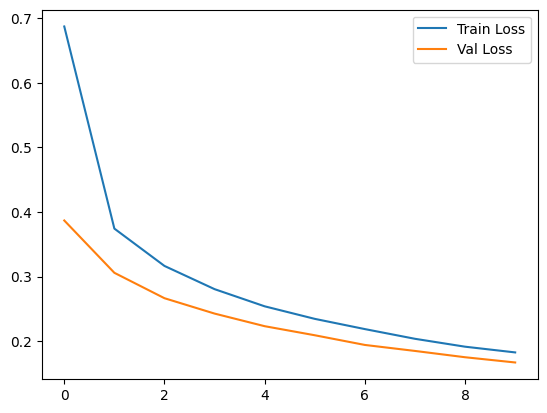

[]


[]

In [122]:
run_experiments(
    models=config['models'],
    lrs=config['lr'],
    optimizers=config['optimizers']
)

Лучшая комбинация параметров, которая дала лосс на валидационной выборке 0.0836:
- lr: 0.01
- optim: Momentum
- BatchNorm = True